# Тестовое задание соискателя
### на вакансию "Исследователь научного центра"

Задача - проанализировать датасет, состоящий из метаданных о научных публикациях. Необходимо:
* Выделить количество публикаций, посвященных исследованию российских реалий;
* Составить топ-20 организаций по количеству авторов, а также по количеству публикаций
* Составить топ-20 авторов по количеству публикаций
* Составить топ-20 журналов по количеству публикаций

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('ranking_dataset.csv',encoding='utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21788 entries, 0 to 21787
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            21788 non-null  object
 1   authour_name  21788 non-null  object
 2   title         21788 non-null  object
 3   address       21788 non-null  object
 4   issn          21302 non-null  object
 5   journal       21788 non-null  object
 6   year          21788 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


## Предобработка данных

In [7]:
data['full_address'] = data['address'].str.split(',',expand=False)
data['org_name'] = data['full_address'].str[0]
data['country'] = data['full_address'].str[-1]

Изучим полученный результат.

In [8]:
display(data[['org_name','country']])

,org_name,country
0,Vytautas Magnus Univ,Lithuania.
1,Northwestern Univ,IL 60208 USA.
2,Ural State Univ Econ,Russia.
3,Ural State Univ Econ,Russia.
4,Ural State Univ Econ,Russia.
...,...,...
21783,Stanford Univ,CA 94305 USA.
21784,Natl Res Univ Higher Sch Econ,Russia.
21785,Univ Helsinki,Finland.
21786,Vytautas Magnus Univ,Lithuania.


В название стран попали точки в конце строки, а также адресы в США сопровождаются названием штата и индексом. Исправим это.
Также заодно избавимся от вспомогательного столбца, который мы создали ранее, чтобы оставить среди данных только скалярные значения.

In [9]:
data.loc[data['country'].str.contains('USA'), 'country'] = 'USA'
data['country'] = data['country'].str.strip(' .')
data = data.drop('full_address', axis=1)

In [10]:
display(data['country'].unique())

array(['Lithuania', 'USA', 'Russia', 'Czech Republic', 'England',
       'Netherlands', 'Israel', 'South Korea', 'Finland', 'Sweden',
       'Scotland', 'Australia', 'Switzerland', 'Serbia', 'Belgium',
       'Peoples R China', 'Estonia', 'Germany', 'Guyana', 'Canada',
       'Taiwan', 'Could not be extracted', 'South Africa', 'Denmark',
       'New Zealand', 'Kazakhstan', 'Ireland', 'Norway', 'Italy',
       'Poland', 'France', 'Malaysia', 'Brazil', 'Singapore', 'Wales',
       'Spain', 'Turkey', 'Japan', 'North Ireland', 'Hungary', 'Ukraine',
       'BELARUS', 'Austria', 'India', 'Slovakia', 'Iran', 'Slovenia',
       'Portugal', 'Croatia', 'Romania', 'Latvia', 'Bulgaria',
       'U Arab Emirates', 'Cyprus', 'Armenia', 'Georgia', 'Qatar',
       'Egypt', 'Vietnam', 'Azerbaijan', 'Sri Lanka'], dtype=object)

Готово. При проверке уникальных значений названий стран обнаруживаем также значение "Could not be extracted". Разберемся, откуда оно взялось.

In [11]:
display(data[data['country'] =='Could not be extracted']['address'])

110      Could not be extracted
179      Could not be extracted
231      Could not be extracted
247      Could not be extracted
290      Could not be extracted
                  ...          
21501    Could not be extracted
21510    Could not be extracted
21628    Could not be extracted
21629    Could not be extracted
21671    Could not be extracted
Name: address, Length: 460, dtype: object

Похоже, что дело в неполноте изначальных данных. Пожалуй, заменим все эти значения на NaN.

In [12]:
data = data.replace('Could not be extracted', np.nan)
print(data.isna().sum())

id                0
authour_name      0
title             0
address         460
issn            486
journal           0
year              0
org_name        460
country         460
dtype: int64


Обнаружив в процессе дальнейшего анализа неявные дубликаты в названиях организации среди топ-20 (а именно - разные названия НИУ ВШЭ), я решил вернуться на этот этап и устранить их, унифицировав названия Московской ВШЭ и Петербургской ВШЭ. Остальные варианты встречаются крайне редко в таком объеме данных, поэтому их трогать не будем.

Та же самая история с попавшим в один из рейтингов РУДН и МГУ им. Ломоносова.

In [13]:
data_check = data.dropna()
display(data_check.loc[data_check['org_name'].str.contains('Natl Res Univ', na=False)]['org_name'].value_counts())

data.loc[(data['org_name'].str.contains('Natl Res Univ', na=False)) & (data['address'].str.contains('Moscow', na=False)),'org_name'] = 'HSE Moscow'
data.loc[data['org_name'].str.contains('Natl Res Univ', na=False) & data['address'].str.contains('Petersburg', na=False),'org_name'] = 'HSE SPb'

data.loc[data['org_name'] == 'Peoples Friendship Univ Russia'] = 'RUDN Univ'
data.loc[(data['org_name'].str.contains('Lomonosov', na=False)), 'org_name'] = 'Lomonosov Moscow State Univ'

Natl Res Univ                           757
Natl Res Univ Higher Sch Econ           589
Belgorod State Natl Res Univ             46
Natl Res Univ Higher Sch Econ HSE        28
Belgorod Natl Res Univ                   24
Perm State Natl Res Univ                 18
Samara Natl Res Univ                      8
Natl Res Univ Moscow Power Engn Inst      4
Natl Res Univ High Sch Econ               1
Natl Res Univ Higher Sch Econ Moscow      1
Moscow Aviat Inst Natl Res Univ           1
Name: org_name, dtype: int64

## Анализ данных по поставленным задачам

Посчитаем количество публикаций, содержащих в своем названии "Russia" или "Russian".

Здесь я использую метод lower() для того, чтобы, переведя все названия в нижний регистр, по одному ключу "russia" найти все вхождения. Также отмечу, что "russian" тоже попадет в выборку, так как комбинация символов "russia" в нем присутствует.

Также я использую метод unique(), поскольку в таблице одна и та же статья занимает несколько строк - по количеству ее авторов.

In [14]:
papers_abt_russia = len(data.loc[data['title'].str.lower().str.contains('russia'),'title'].unique())
print('Количество публикаций, в названии которых упоминается "Russia" или "Russian":', papers_abt_russia)
print('Доля таких публикаций ', papers_abt_russia/len(data['title'].unique()))

Количество публикаций, в названии которых упоминается "Russia" или "Russian": 4825
Доля таких публикаций  0.4325414612281488


### Топ-20 организаций: по авторам

Перейдем к составлению рейтингов Топ-20.

Для Топ-20 организаций по количеству авторов я использую лямбда-функцию в сводной таблице, чтобы удостовериться, что каждый уникальный автор будет посчитан только единожды.

In [15]:
top_facilities_by_authors = data.pivot_table(index='org_name', values='authour_name', aggfunc=lambda x: len(x.unique())).sort_values(by='authour_name', ascending=False).head(20)

In [16]:
display(top_facilities_by_authors)

,authour_name
org_name,
Kazan Fed Univ,2083
HSE Moscow,814
St Petersburg State Univ,484
Lomonosov Moscow State Univ,329
Belgorod State Univ,246
Kazan Volga Reg Fed Univ,198
Stavropol State Agr Univ,180
Russian State Social Univ,164
Plekhanov Russian Univ Econ,159


Построим простенький график, чтобы более наглядно проиллюстрировать разрыв между лидерами:

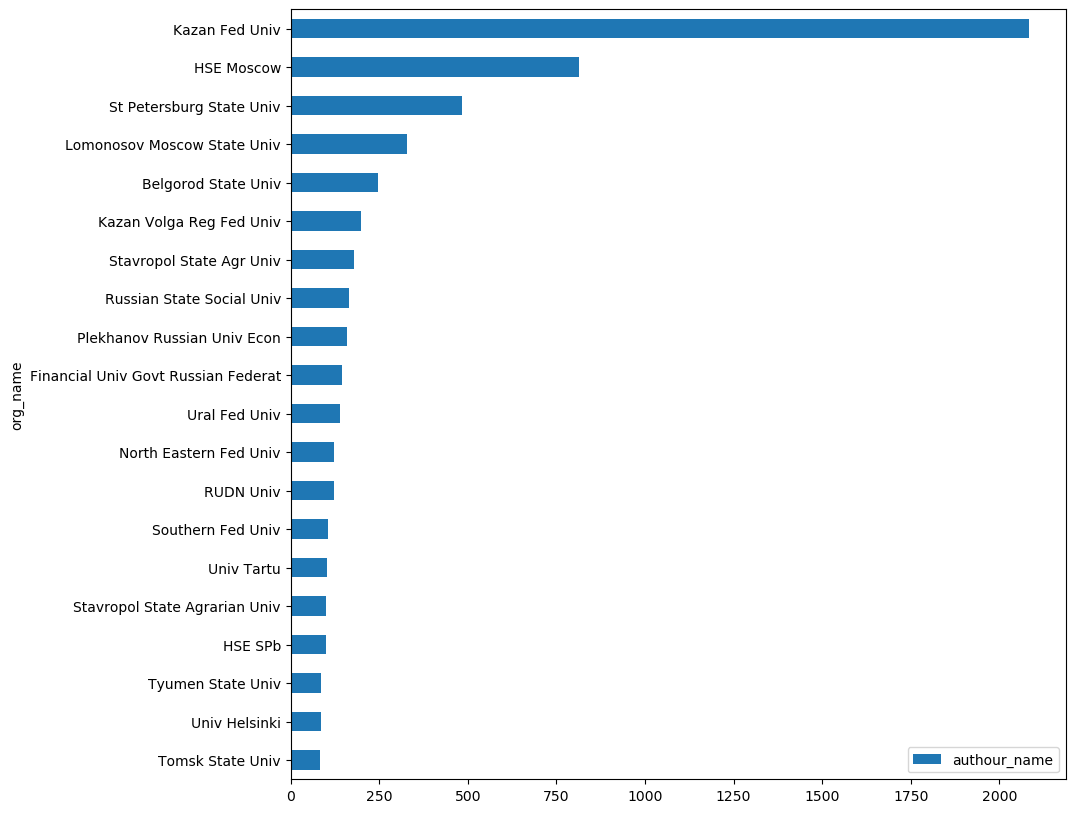

In [17]:
top_facilities_by_authors.sort_values(by='authour_name', ascending=True).plot(kind='barh',figsize=(10,10))
plt.show()

P.S.: Казанский Федеральный Университет лидирует с огромным отрывом (более чем в 2 раза больше авторов, чем у следующего за ним учреждения).
Следом за ним - НИУ ВШЭ в Москве, далее СПбГУ, Белгородский государственный университет и МГУ, причем с каждой позицией от 1 до 4 количество авторов уменьшается примерно вдвое.

### Топ-20 организаций: по количеству публикаций

In [18]:
top_facilities_by_papers = data.pivot_table(index='org_name', values='title', aggfunc=lambda x: len(x.unique())).sort_values(by='title', ascending=False).head(20)

In [19]:
display(top_facilities_by_papers)

,title
org_name,
Kazan Fed Univ,1234
HSE Moscow,748
St Petersburg State Univ,376
Lomonosov Moscow State Univ,256
Plekhanov Russian Univ Econ,124
Ural Fed Univ,111
Kazan Volga Reg Fed Univ,104
Russian State Social Univ,103
HSE SPb,102


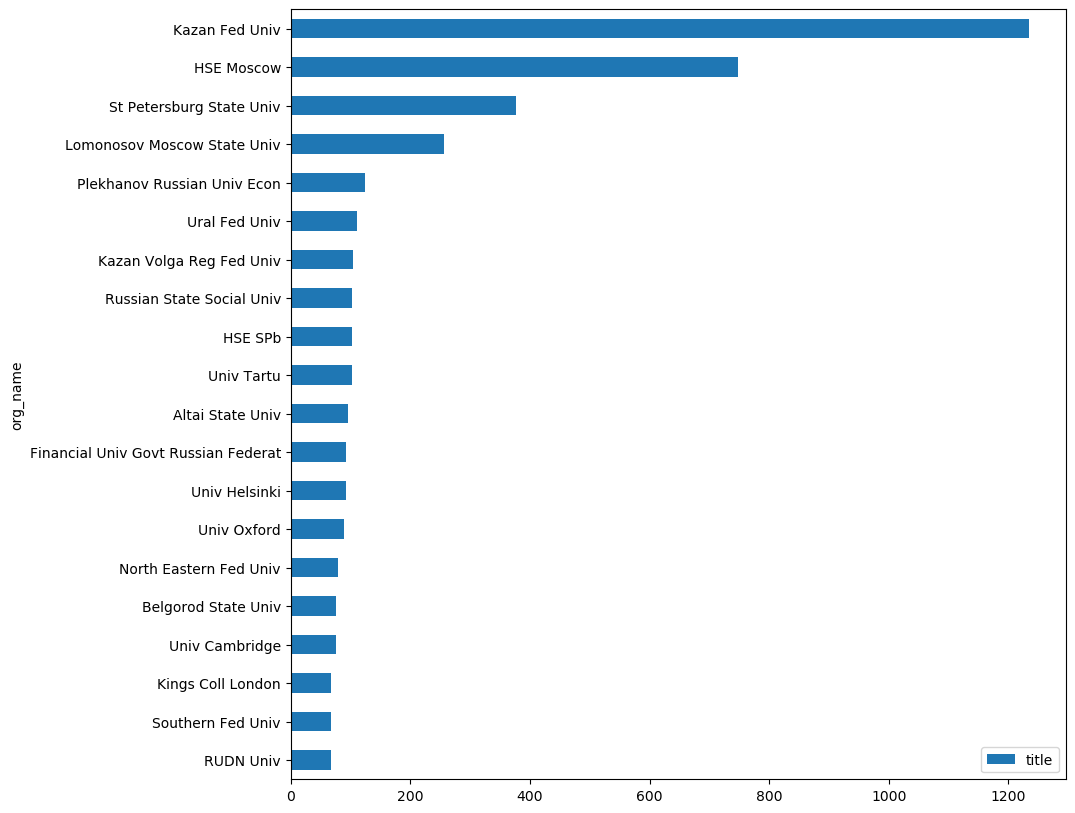

In [20]:
top_facilities_by_papers.sort_values(by='title', ascending=True).plot(kind='barh',figsize=(10,10))
plt.show()

Здесь мы наблюдаем аналогичную картину, однако разрыв уже чуть меньше. Белгородский государственный институт исчез из первой пятерки и сместился в конец топа.


In [21]:
top_authors_by_papers = data.pivot_table(index='authour_name', values='title', aggfunc=lambda x: len(x.unique())).sort_values(by='title', ascending=False).head(20)

In [22]:
display(top_authors_by_papers)

,title
authour_name,
"Zamaletdinov, Radif R.",24
"Kovalenko, Kseniya",23
"Kovalenko, Kseniya E.",21
"Zhatkin, Dmitry N.",21
"Gubareva, Anna",16
"Zaitseva, Natalia A.",16
"Souleimanov, Emil Aslan",16
"Fedorov, Alexander",14
"Larionova, Anna A.",14


Тут та же проблема, что и с названиями организаций: кажется, возник дубликат (второй и третий автор в списке - Коваленко Ксения). Все дубликаты имен устранить невозможно, поэтому хорошо бы иметь в базе ORCID ID.
Здесь же можно выполнить замену значений, но это необязательно для ориентировочного анализа. Все же выведем более корректный список:

In [23]:
data.loc[data['authour_name'] == 'Kovalenko, Kseniya', 'authour_name'] = 'Kovalenko, Kseniya E.'
top_authors_by_papers = data.pivot_table(index='authour_name', values='title', aggfunc=lambda x: len(x.unique())).sort_values(by='title', ascending=False).head(20)

display(top_authors_by_papers)

,title
authour_name,
"Kovalenko, Kseniya E.",44
"Zamaletdinov, Radif R.",24
"Zhatkin, Dmitry N.",21
"Souleimanov, Emil Aslan",16
"Gubareva, Anna",16
"Zaitseva, Natalia A.",16
"Safiullin, Marat R.",14
"Larionova, Anna A.",14
"Fedorov, Alexander",14


И Ксения Коваленко лидирует.

### Топ-20 журналов по публикациям

In [24]:
top_journals_by_papers = data.pivot_table(index='journal', values='title', aggfunc=lambda x: len(x.unique())).sort_values(by='title', ascending=False).head(20)

In [25]:
display(top_journals_by_papers)

,title
journal,
MODERN JOURNAL OF LANGUAGE TEACHING METHODS,374
RESEARCH JOURNAL OF PHARMACEUTICAL BIOLOGICAL AND CHEMICAL SCIENCES,284
AMAZONIA INVESTIGA,248
TARIH KULTUR VE SANAT ARASTIRMALARI DERGISI-JOURNAL OF HISTORY CULTURE\n\nAND ART RESEARCH,233
AD ALTA-JOURNAL OF INTERDISCIPLINARY RESEARCH,187
TURKISH ONLINE JOURNAL OF DESIGN ART AND COMMUNICATION,176
EUROPE-ASIA STUDIES,157
DILEMAS CONTEMPORANEOS-EDUCACION POLITICA Y VALORES,144
PSYCHOLOGY IN RUSSIA-STATE OF THE ART,110
